# Assignment 1 Polynomial regression, KNN, MLP, FCN

# import libraries

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn import svm, tree 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, List
import random 
import itertools
import torch
from torch import nn, optim 
import torchvision.datasets as datasets

# problem 1 Polynomial regression

least square solution $$\mathbf{w}^* = (X^TX)^{-1} X^T\textbf{y}$$

## generate data from quadratic function

quadratic function $y = x^2 - 3x + 1$

randomly uniformly samples $N \in \left \{15, 100 \right \}$ points  in the interval $x \in [- 1, 3]$.

adds Gaussian noise $N(0, \sigma^2)$ to $y$, $\sigma \in \left \{0, 0.05,0.2 \right \}$. 

plot 6 scatterplot of $x$ and $y$


In [11]:
def evaluate_function_on_random_noise(N: int=15, mu: float=0, sigma: float=0, x_min: float=-1, x_max: float=3) -> Tuple[np.array, np.array]:
    """Evaluate function y = x^2 - 3x + 1 on N points uniformly sampled from interval [x_min, x_max],
        with random Gaussian noise N(mu, sigma^2)

    Parameters
    N: sample size 
    mu: mean 
    sigma: standard deviation 
    x_min: lower bound of interval 
    x_max: upper bound of interval

    Returns
    x: (N, ) 
    y: (N, )
    """
    x = np.linspace(x_min, x_max, N) 
    noise = np.random.normal(mu, sigma, N)
    y = x**2 - 3*x + 1 + noise
    
    return x, y 


## fit polynomial function

Find the optimal weights (in terms of MSE) for fitting a polynomial function using degree 1, 2, and 9 to the data in all 6 cases generated above.  

Use the least squares analytical solution given above. 

plot all 3 polynomial curves on the same plot. 

Report fitted weights and MSE in tables. 

Qualitatively assess the fit of the curves: overfitting, underfitting, or appropriately fit 

- answer: when degree is 1, the model is underfitting because it doesn't go through most of data points, a linear function can't fit data generated from a quadratic function; when degree is 2, the model appropriately fit the data, because it goes through lots of data points perfectly and the original function is exactly quadratic; when degree is 9, the model is overfitting, it wiggly goes through most data points, but we don't need so much parameters for fitting a quadratic function.

In [19]:
def fit_polynomial(x: np.array, y: np.array, degree: int=1, lbda: float = 0) -> Tuple[np.array, np.array, np.array]:
    """Polynomial regression

    Parameters
    ----------
    x: (N, )
    y: (N, )
    lbda: lambda regularization level

    Returns
    coeffs: estimated coefficients (degree+1)
    haty: predicted y (N, )
    MSE: mean squared error, a scalar
    """
    X = np.zeros((x.shape[0], degree+1))
    for i in range(degree+1):
        X[:,i] = x**i 
    # Moore-Penrose Pseudoinverse
    coeffs = np.linalg.inv(lbda*np.identity(degree+1) + X.T@X)@X.T@y 

    haty = coeffs.T@X.T
    mse = np.mean((haty - y)**2)
    return coeffs, haty, mse


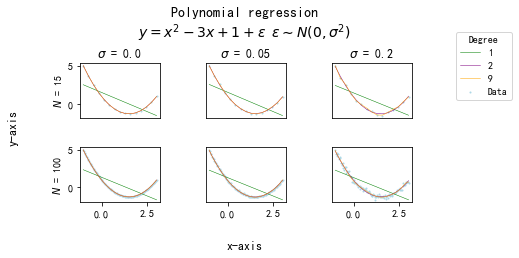

In [37]:
degrees = [1, 2, 9] # degree of polynomial
Ns = [15, 100] # number of data points
sigmas = [0.00, 0.05, 0.20] # standard deviation
colors = ['green', 'purple', 'orange']


fig, axes = plt.subplots(len(Ns), len(sigmas), figsize=(6,3.5))
fig.suptitle("Polynomial regression\n$y=x^2-3x+1+\epsilon$ $\epsilon \sim N(0, \sigma^2)$", fontsize=14, x=0.57)
fig.tight_layout(rect=(0.1,0.1,1,1))
fig.supxlabel('x-axis', x=0.57) # global x axis
fig.supylabel('y-axis') # global y axis


ws = [[] for _ in range(len(degrees))] # weights for a certain degree
mses = [[] for _ in range(len(degrees))] # MSE for a certain degree
for i, N in enumerate(Ns):
    for j, sigma in enumerate(sigmas):
        x, y = evaluate_function_on_random_noise(N=N, sigma=sigma)
        axes[i,j].scatter(x, y, s=1, color="lightblue", label='Data')
        for k, (degree, color) in enumerate(zip(degrees, colors)):
            w, hat_y, mse = fit_polynomial(x, y, degree=degree)
            
            axes[i,j].plot(x, hat_y, linewidth=0.5, color=color, label=f"{degree}")
            
            ws[k].append(w), mses[k].append(mse)
            
        if i == 0:
            axes[i,j].set_title(rf"$\sigma$ = {sigma}")
            axes[i,j].set_xticks([])
        if j == 0:
            axes[i,j].set_ylabel(rf"$N$ = {N}")
        else:
            axes[i,j].set_yticks([])

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title="Degree", bbox_to_anchor=(1.2, 0.9)) 
plt.show()

for k, degree in enumerate(degrees):
    df = pd.concat([pd.DataFrame(mses[k]), pd.DataFrame(ws[k])], axis=1)
    df.columns = ['MSE'] +[f"w_{i}" for i in range(degree+1)] 
    df.index = pd.MultiIndex.from_product([Ns, sigmas], names=["N", "Sigma"])
    df = df.style.set_caption(f"Fitted weights and MSE for degree {degree}")
    display(df)

## l-2 norm regularization

Apply l-2 norm regularization with a 9-degree polynomial model to data with $\sigma = 0.05$ and $N \in \left \{15, 100 \right \}$. 

Vary the parameter $\lambda$, and choose three values of $\lambda$ that result in the following scenarios: underfitting, overfitting, and an appropriate fit. 

Report fitted weights and MSE in each of these scenarios. 

least square solution of Ridge regresssion:

$$
\mathbf{w}^* = (\lambda I+X^TX)^{-1} X^T\textbf{y}
$$

where $\lambda >0$ is a regularization factor

- answer: when lambda is 0.001, the model is overfitting; when lambda is 1, the model is an appropriate fit; when lambda is 100, the model is underfitting

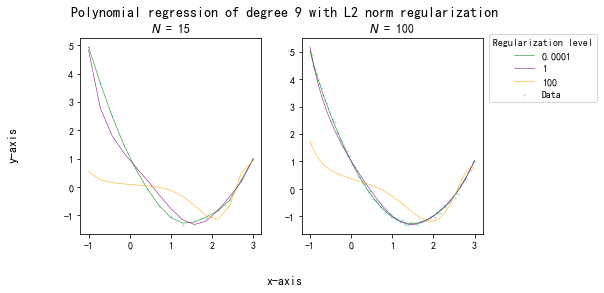

In [40]:
Ns = [15, 100]
lbdas = [.0001, 1, 100] 
colors = ['green', 'purple', 'orange']
sigma = 0.05 
degree = 9

fig, axes = plt.subplots(1, len(Ns), figsize=(7,4))
fig.suptitle("Polynomial regression of degree 9 with L2 norm regularization", fontsize=14, x=0.57)
fig.tight_layout(rect=(0.1,0.1,1,1))
fig.supxlabel('x-axis', x=0.57) # global x axis
fig.supylabel('y-axis') # global y axis

ws = [] # weights
mses = [] # MSE
for i, N in enumerate(Ns):
    x, y = evaluate_function_on_random_noise(N=N, sigma=sigma)
    axes[i].scatter(x, y, s=1, color="lightblue", label='Data')
    axes[i].set_title(rf"$N$ = {N}") 
    for j, (lbda, color) in enumerate(zip(lbdas, colors)):
        w, hat_y, mse = fit_polynomial(x, y, degree=degree, lbda=lbda)
        axes[i].plot(x, hat_y, linewidth=0.5, color=color, label=f"{lbda}")
        ws.append(w), mses.append(mse)
    

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Regularization level", bbox_to_anchor=(1.2, 0.9)) 
plt.show()


df = pd.concat([pd.DataFrame(mses), pd.DataFrame(ws)], axis=1)
df.columns = ['MSE'] +[f"w_{i}" for i in range(degree+1)] 
df.index = pd.MultiIndex.from_product([Ns, sigmas], names=["N", "Lambda"])
df = df.style.set_caption(f"Fitted weights and MSE for polynomial of degree {degree} with L2 regularization")
display(df)
   

# problem 2 KNN classification

- 7 features:

    1. area A, 

    2. perimeter P, 

    3. compactness C = $4\pi A/P^2$,
    
    4. length of kernel, 

    5. width of kernel, 

    6. asymmetry coefficient 

    7. length of kernel groove. 


- label: 3 classes: 1 (70), 2 (70), 3 (70)

## min-max scaling

normalize features using min-max scaling so that each feature has the same range of values.

- min-max scaling

$$
x' = \frac{x-\min(x)}{\max(x)-\min(x)}
$$

In [47]:
# load dataset
data = np.loadtxt('/Users/wenxinxu/Desktop/CPSC552/data/problem3_data_seed.dat', dtype=float)
X = data[:,:-1] # (210, 7) 210 samples * 7 features
y = data[:,-1] # (210, ) response, {1.0: 70, 2.0: 70, 3.0: 70}
# min-max scaling
X = (X - np.min(X, axis=0))/(np.max(X, axis=0) - np.min(X, axis=0)) 

## KNN classifier

implement a k-nn classifier 

apply to data with $k \in \left \{1, 5,10, 15 \right \}$. 

Calculate test error using both leave-one-out validation and 5-fold cross validation. 

Plot the training error and test error as a function of k. 

Do any values of k result in underfitting or overfitting?

In [43]:
class knn():
    """
    KNN classifier 
    """
    def __init__(self, k: int):
        """
        k: number of neighbors to consider, an integer in [1, n]
        """
        self.k = k 
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        X_train: training data, shape (n, p) 
        y_train: labels of training data, shape (n,)
        """
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        X_test: test data, shape (m, p)
        
        return
        y_hat: predicted labels, shape (m,) 
        """
        # pairwise distance matrix of test data and training data, shape (m, n)
        dist = np.linalg.norm(X_test[:,None,:]-self.X_train[None,:,:],axis=-1)

        # neighbors shape (m, k) 
        neighbors = np.argsort(dist, axis=1)[:,:self.k] 
        y_hat = self.y_train[stats.mode(neighbors,axis=1,keepdims=True)[0]].flatten()
        
        return y_hat

In [42]:
def kfold_split(X: np.ndarray, K: int=5) -> Tuple[List, List]: 
    """
    split dataset into K even folds
    
    @param:
    X: features, shape (n, p)
    K: number of folds, default to 5
    
    return:
    train_id: index of training data, length = n*(1-1/K)
    test_id: index of test data, length = n/K
    """
    ids = np.arange(X.shape[0]) 
    random.seed(0)
    random.shuffle(ids)
    folds = np.split(ids, K)
    for i in range(K):
        test_id = list(folds[i]) 
        train_id = [fold for j, fold in enumerate(folds) if j!= i]
        train_id = list(itertools.chain(*train_id))
        yield train_id, test_id 

In [41]:
def kfoldCV(X: np.ndarray, y: np.ndarray, clf, K: int=5) -> Tuple[float, float]:
    """
    X: features, shape (n, p) 
    y: labels, shape (n,)
    clf: classifier
    K: number of folds, default to 5
    
    return:
    train_error: misclassification error rate of training, range [0, 1]
    test_error: misclassification error rate of test, range [0, 1]
    """
    train_count, test_count = 0, 0
    for train_id, test_id in kfold_split(X, K):
        X_train, X_test, y_train, y_test = X[train_id], X[test_id], y[train_id], y[test_id]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        yhat_test = clf.predict(X_test)
        train_count += np.sum(yhat_train!=y_train) 
        test_count += np.sum(yhat_test!=y_test)
    train_error = train_count/(X.shape[0] * (K-1)) 
    test_error = test_count/X.shape[0]
    
    return train_error, test_error

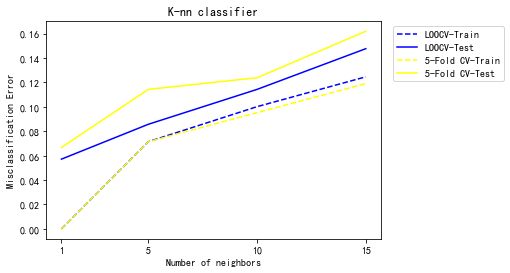

In [54]:
# Leave-one-out CV and 5-fold CV
num_folds = [X.shape[0], 5] # number of folds
num_neighbors = [1, 5, 10, 15]  # number of neighbors
labels = ['LOOCV', '5-Fold CV']
colors = ['blue', 'orange']
train_errors = np.zeros((len(num_folds), len(num_neighbors)))
test_errors = np.zeros((len(num_folds), len(num_neighbors)))

for i, (num_fold, label, color) in enumerate(zip(num_folds, labels, colors)):
    for j, num_neighbor in enumerate(num_neighbors):
        clf = knn(num_neighbor) 
        train_errors[i][j], test_errors[i][j] = kfoldCV(X, y, clf, num_fold)     
        
    plt.plot(num_neighbors, train_errors[i], '--', color=color, label=label+"-Train") 
    plt.plot(num_neighbors, test_errors[i], '-', color=color, label=label+"-Test") 

plt.title("K-nn classifier")
plt.xlabel("Number of neighbors")
plt.ylabel("Misclassification Error")
# plt.ylim(0.04, 0.2)
plt.xticks(num_neighbors)
plt.legend(bbox_to_anchor=(1.02,1)) 
 

In [56]:
index = np.unravel_index(test_errors.argmin(), test_errors.shape)
i, j = index 
params = {'num_neighbor': num_neighbors[j]}
print(f"Min test error: {test_errors[index]}, parameters: {params}")

Min test error: 0.05714285714285714, parameters: {'num_neighbor': 1}


- answer: from the plot of test error vs. k, we can see as k increases, the test error increases no matter which cross validation methods we choose

    given the labels are 3 classes with equal numbers, the baseline classification accuracy is 1/3.
    
    when k = 1, model is overfitting
    
    when k = 5-10, model fits well
    
    when k = 15, model is underfitting

## other classifiers

Apply **two other classifiers** to the same data. (logistic regression, QDA, naive Bayes, SVM, and decision trees.)
    
If any tuning parameters need to be selected, use cross-validation and report the training and test error for several values of the tuning parameters. 

Which of the classifiers performed best?  

Did any of them underfit or overfit the data? 

How do they compare to the k-nn classifiers in terms of performance?

### SVM

[sklearn svm.SVC](https://scikit-learn.org/stable/modules/svm.html)

SVM has 3 hyperparameters:

- kernel: kernel function {‘linear’, ‘poly’, ‘rbf’- default, ‘sigmoid’, ‘precomputed’}

- C: default=1.0. inverse L2 norm regularization parameter.

- gamma: Kernel bandwidth for ‘rbf’, ‘poly’ and ‘sigmoid’. {‘scale’, ‘auto’} or float, 

    if gamma='scale', uses 1 / (n_features * X.var())
    
    if ‘auto’, uses 1 / n_features.


In [57]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [1000, 100, 10, 1, 0.1] 
gammas = ['scale', 'auto']

train_errors = np.zeros((len(kernels), len(Cs), len(gammas)))
test_errors = np.zeros((len(kernels), len(Cs), len(gammas)))

for i, kernel in enumerate(kernels):
    for j, C in enumerate(Cs):
        for k, gamma in enumerate(gammas):
            clf = svm.SVC(kernel=kernel, gamma=gamma, C=C) 
            train_errors[i][j][k], test_errors[i][j][k] = kfoldCV(X, y, clf, K=5)

index = np.unravel_index(test_errors.argmin(), test_errors.shape)
i, j, k = index 
params = {'kernel': kernels[i], 'C': Cs[j], 'gamma': gammas[k]}
print(f"Min test error: {test_errors[index]}, parameters: {params}")

Min test error: 0.02857142857142857, parameters: {'kernel': 'poly', 'C': 1000, 'gamma': 'scale'}


### decision tree

`sklearn.tree.DecisionTreeClassifier`

- `min_sample_split`: int or float, default=2. the minimum number of samples required to split an internal node
    
    
- `min_samples_leaf` int or float, default=1. The minimum number of samples required to be at a leaf node. This may have the effect of smoothing the model, especially in regression.

- difference between this 2 params:

    https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre
    
    internal node: a node can be further split to have children
    
    leaf (external node): a node without any children 
    
    e.g, if `min_samples_split` = 5, and there are 7 samples at an internal node, then the split is allowed. 
    
    if the split results in two leaves, **one with 1 sample**, and another with 6 samples. 
    
    If `min_samples_leaf` = 2, then the split won't be allowed, because one of the leaves resulted will **1 < 2**

In [60]:
min_samples_splits = [2**i for i in range(1, 6)]
min_samples_leafs = np.arange(1, 6) 
train_errors = np.zeros((len(min_samples_splits), len(min_samples_leafs)))
test_errors = np.zeros((len(min_samples_splits), len(min_samples_leafs)))
for i, min_samples_split in enumerate(min_samples_splits):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf)
        train_errors[i][j], test_errors[i][j] = kfoldCV(X, y, clf, K=5)

index = np.unravel_index(test_errors.argmin(), test_errors.shape)
i, j = index 
params = {'min_samples_split': min_samples_splits[i], 'min_samples_leaf': min_samples_leafs[j]}
print(f"Min test error: {test_errors[index]}, parameters: {params}")       

Min test error: 0.08571428571428572, parameters: {'min_samples_split': 4, 'min_samples_leaf': 1}


### conclusion

- How do they compare to the k-nn classifiers in terms of performance?

    performance: KNN > SVM > Decision tree (test error 0.057, 0.067, 0.095, respectively)
    
    KNN performs best
    
    decision tree overfit data

# problem 3 MLP

## identity activation is scale invariant

Show that the behavior of the network doesn't change if multiply all the weights and biases in a network of perceptrons by a positive constant, c > 0. 

The output of a perceptron is 

$$
\text { output }=\left\{\begin{array}{ll}0 & \text { if } \textbf{w}^T \textbf{x} + b \leq 0 \\ 1 & \text { if } \textbf{w}^T \textbf{x} + b>0\end{array}\right.
$$

 multiplying all the weights and biases by a constant $c \ (c>0)$, the output becomes:
 
$$
\text { output }=\left\{\begin{array}{ll}0 & \text { if } c \cdot \textbf{w}^T \textbf{x}+ c \cdot b = c \cdot (\textbf{w}^T \textbf{x} + b) \leq 0 \\ 1 & \text { if } c \cdot \textbf{w}^T \textbf{x}+ c \cdot b = c \cdot (\textbf{w}^T \textbf{x} + b)>0\end{array}\right.
$$

because the sign of the quantity $c \cdot (\textbf{w}^T \textbf{x} + b)$ doesn't change, the output (behavior) of the network doesn't change

## sigmoid activation is not scale invariant

suppose that overall input to the network of perceptrons has been chosen and fixed. 

Now replace all the perceptrons in the network by **sigmoid neurons**, 

and multiply the weights and biases by a positive constant c > 0. 

Show that in the limit as $c \rightarrow \infty$ the behavior of this network of sigmoid neurons is exactly the same as the network of perceptrons.  

How can this fail when $wx + b = 0$ for one of the perceptrons?  

- The output of a sigmoid neuron is 

$$
\sigma(\textbf{w}^T \textbf{x} + b)=\frac{1}{1+\exp \left[-(\textbf{w}^T \textbf{x} + b)\right]}
$$


- Replacing all perceptrons in the network by sigmoid neurons and multiply the weights and biases by a positive constant $c > 0$, 

    for a neuron, we have:

$$
\sigma(c (\textbf{w}^T \textbf{x} + b)) = \frac{1}{1+\exp \left[-c(\textbf{w}^T \textbf{x} + b)\right]}
$$


- Suppose $\textbf{w}^T \textbf{x}+b \ne 0$, as $c \to \infty$

    If $\textbf{w}^T \textbf{x}+b < 0$, 
    
    $$
    \lim_{c \to \infty}\frac{1}{1+\exp \left[-c (\textbf{w}^T \textbf{x} + b)\right]} = \frac{1}{1+\exp \left(+\infty\right)}= \frac{1}{+\infty} = 0
    $$

    If $\textbf{w}^T \textbf{x}+b > 0$, 
    
    $$
    \lim_{c \to \infty}\frac{1}{1+\exp \left[-c (\textbf{w}^T \textbf{x} + b)\right]}= \frac{1}{1+\exp (-\infty )} = \frac{1}{1+0} = 1
    $$

    which is same as the behavior of the network of perceptrons. 


- When $\textbf{w}^T \textbf{x}+b = 0$ for one of the perceptrons, then

    $$
    \sigma(c (\textbf{w}^T \textbf{x} + b)) = \sigma(0) = \frac{1}{1+\exp (0)}=\frac{1}{2}
    $$ 
    
    which is different from the behavior of perceptron, so it fails. 

## step activation

For each possible input of the MLP in Figure 1, calculate the output.  

I.e., what is the output if X = [0,0, 0], X =  [0, 0,1], etc. 

You should have 8 cases total.


In [634]:
def MLP(X: np.ndarray, W1: np.ndarray, W2: np.ndarray, 
        b1: np.ndarray, b2: np.ndarray, activation: callable) -> np.ndarray:
    """
    implement a one-hidden-layer MLP
    
    X: input, shape (n, d)
    W1: weights of hidden layer, shape (d, h)
    W2: weights of output layer, shape (h, q)
    b1: bias of hidden layer, shape (h, )
    b2: bias of output layer, shape (q, )
    
    return
    O: outputs, shape (n, q)
    """
    H = activation(X@W1 + b1)
    O = activation(H@W2 + b2)
    return O

In [ ]:
def step(x): 
    x[x >= 0] = 1
    x[x < 0] = 0
    return x

In [606]:
X = np.array(list(itertools.product([0,1], repeat=3))) 

In [628]:
w1 = 0.6
w2 = -0.7
w3 = 0.5
w4 = 0.4 
w5 = -0.6 
w6 = 0.8 
w7 = 1 
w8 = 1
b1_1 = -0.4 
b1_2 = -0.5 
b2 = -0.5 

In [629]:
W1 = np.array(
[[w1, w2],
[w3, w4],
[w5, w6]])

W2 = np.array([[w7], [w8]]) 
b1 = np.array([b1_1, b1_2])
b2 = np.array([b2]) 

In [630]:
W1.shape, W2.shape, b1.shape, b2.shape  

((3, 2), (2, 1), (2,), (1,))

- output is 0, 1, 1, 1, 1, 0, 1, 1 for 8 cases respectively

In [635]:
# output
O = MLP(X, W1, W2, b1, b2, step) 
O # 8 * 1

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]])

In [605]:
X = []
for i in [0, 1]:
    for j in [0, 1]:
        for k in [0, 1]:
            X.append([i, j, k])
X = np.array(X)  

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

## sigmoid activation

If we change the perceptrons in Figure 1 to sigmoid neurons,

what are the outputs for the same inputs (e.g., inputs of [0,0,0], [0,0,1], ...)?

In [633]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

In [637]:
O = MLP(X, W1, W2, b1, b2, sigmoid) 
O 

array([[0.569265  ],
       [0.58501229],
       [0.62245933],
       [0.63314399],
       [0.56986717],
       [0.57508402],
       [0.61732588],
       [0.62831133]])

## Adder

5.	Using perceptrons with appropriate weights and biases,  

    design an adder that does two-bit binary addition. 
    
    That is, the adder takes as input 2 two-bit binary numbers 
    
    (i.e. 4 binary inputs) and adds them together. 
    
    Don't forget to include the carry bit. 
    
    The resulting output should be the two-bit sum and the carry bit for a total of three binary outputs.

半加器，全加器

https://zhuanlan.zhihu.com/p/100206901

https://web2.qatar.cmu.edu/~srazak/courses/15348-f19/hw/hw3/hw3.pdf

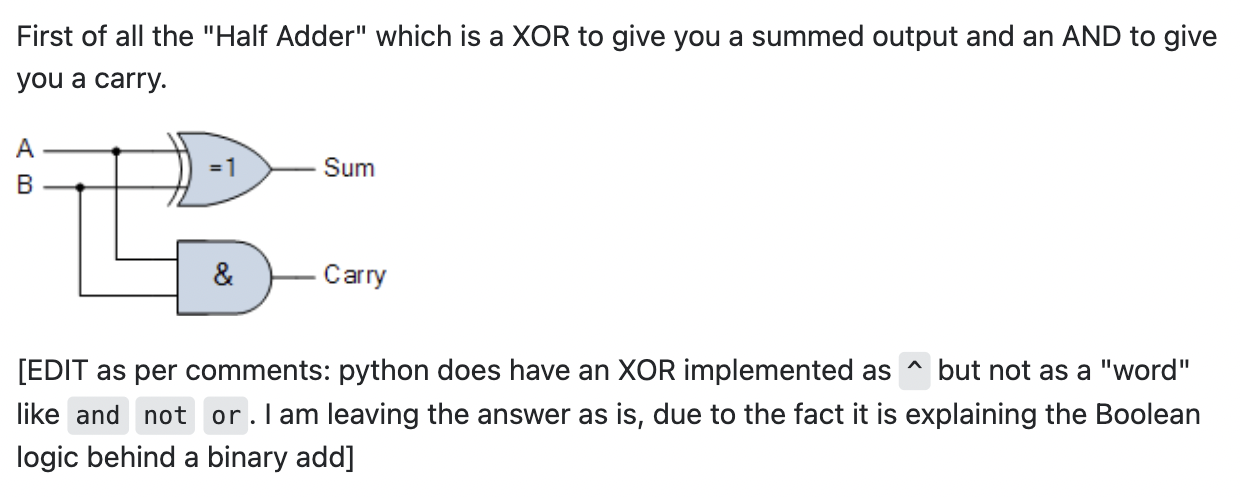

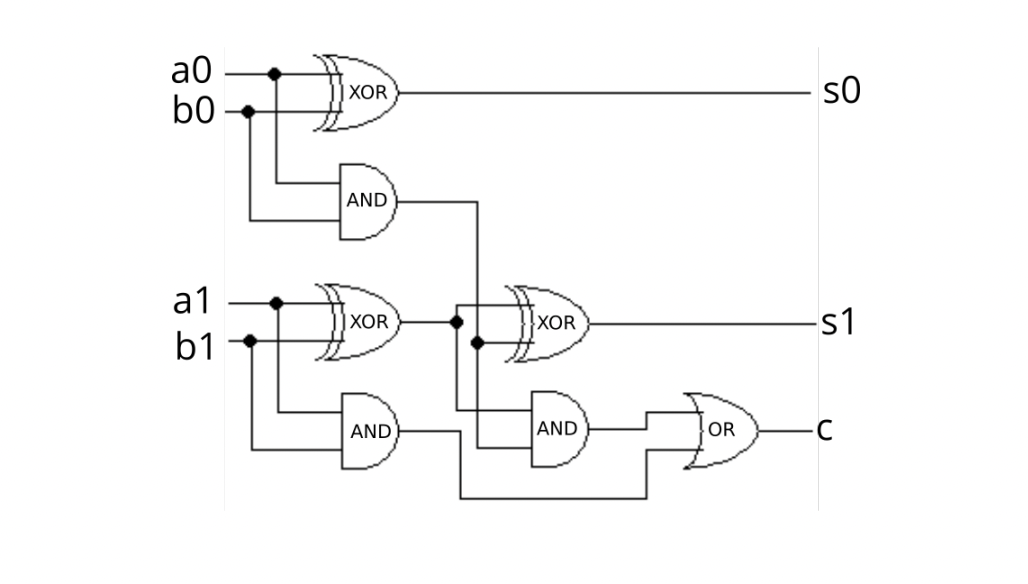

In [1]:
# solution 1
def AND(x, y):
    
    return 1*x+1*y-1 >0

def OR(x, y):
    
    return 2*x+2*y-1 >0
    
def NAND(x, y):
    return (-2)*x+(-2)*y+3 > 0 
    
def XOR(x, y):
    
    return AND(OR(x, y), NAND(x, y)) > 0 


def fourBitHalfAdder(a1: int, a0: int, b1: int, b0: int) -> Tuple[int, int, int]:
    
    s0 = XOR(a0, b0)
    
    s1 = XOR(AND(a0, b0), XOR(a1, b1)) 
    
    c = OR(AND(AND(a0, b0), XOR(a1, b1)), AND(a1, b1))
    
    return c, s1, s0 

In [ ]:
# Solution 2
def step(x): 
    return x>0


def twoBitHalfAdder(x1: int, x2: int) -> Tuple[int, int]:
    """
    x1: 1-bit input
    x2: 1-bit input
    
    return 
    a3: sum of two 1-bit inputs x1 and x2 
    c: carry bit  
    """
    b = 2
    w = np.array([-1, -1]).T 
    x = np.array([x1, x2])
    a1 = step(w @ x + b) 
    a2_1 = step(w @ np.array([x1, a1]) + b)
    a2_2 = step(w @ np.array([x2, a1]) + b)
    c = step(w @ np.array([a1, a1]) + b) 
    s = step(w @ np.array([a2_1, a2_2]) + b) 
 
    return c, s


def fourBitHalfAdder2(a1: int, a0: int, b1: int, b0: int) -> Tuple[int, int, int]:
    """
    a1: second bit of 2-bit input a
    a0: first bit of 2-bit input a
    b1: second bit of 2-bit input b
    b0: first bit of 2-bit input b 
    
    return 
    c: carry bit
    s1: second bit of sum of a and b 
    s0: first bit of sum of a and b 
    """
    c0, s0 = twoBitHalfAdder(a0, b0)
    c1, s0_2 = twoBitHalfAdder(a1, b1) 
    c2, s1 = twoBitHalfAdder(s0_2, c0) 
    _, c = twoBitHalfAdder(c1, c2) 
      
    return c, s1, s0

In [8]:
X = np.array(list(itertools.product([0,1], repeat=4)))  
X 

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

In [ ]:
Y = np.array([
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0]
])

In [9]:
np.array([fourBitHalfAdder(*x) for x in X] ) == Y

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

# problem 4 FCN

- build a two-layer FCNN. in `FCNN.py`

- cross entropy loss with Lp-norm regularization

$$
L = \frac{1}{n}\sum_{i=1}^n CE(\hat y - y) + \lambda \left\| w\right\|_p^p
$$

Lp-norm of weight $w \in \mathbb{R}^d$

$$
\left\| w\right\|_p = \left ( \sum_{j=1}^d \left|w_j \right| ^q\right )^{1/q}
$$

where $\lambda >0$ is regularization level

- pytorch autograd mechanics

    https://pytorch.org/docs/stable/notes/autograd.html


- customize loss function

    https://blog.csdn.net/dss_dssssd/article/details/84103834
    
    same as define normal function
    
    all the math calculation use tensor
    
    **make sure one of tensors must have `requires_grad=True`**
    
    by `SourceTensor.clone().detach().requires_grad_(True)`
    
    then the output of customized loss function will have `grad_fn=` attribute

    



In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape) 

layer1.weight torch.Size([128, 784])
layer1.bias torch.Size([128])
layer2.weight torch.Size([10, 128])
layer2.bias torch.Size([10])


## tuning params

- 6: number of epochs, net's width, depth (number of layers), learning rate, activation function, optimizer to achieve highest classification accuracy


- experiment with these independently and in combination. 
    
    
- Record your test results for each in a table

- What was the highest percentage of classification accuracy your FCN achieved? 

    Briefly describe the architecture and training process that produced it.   


- answer: 

    the highest classification accuracy is 96.3%.

    architecture: 3 layers with ReLU activation function for the 1st layer and 2nd layer; hidden size of the 1st layer is 256, hidden size of the 2nd layer is 128.
    
    training process: learning rate .001, 50 epochs, cross entropy loss with l2-norm regularization ($\lambda=0.01$), optimizer is SGD
    
    

### learning rate 

- Try adjusting the learning rate (by making it smaller) if your model is not converging/improving in accuracy.



- learning rate 0.001 is the best

    The best validation accuracy of 95.100 occurred after epoch 48.

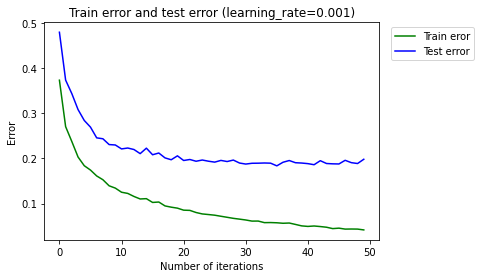

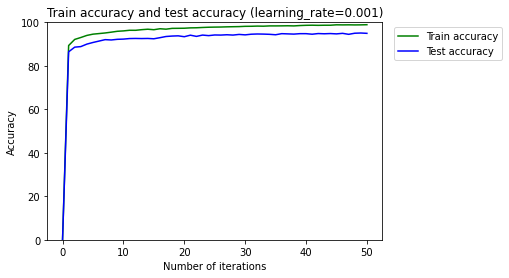

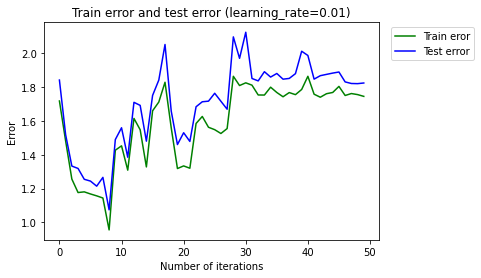

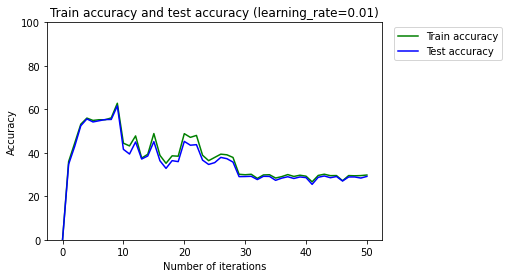

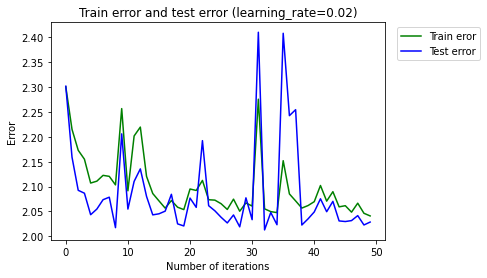

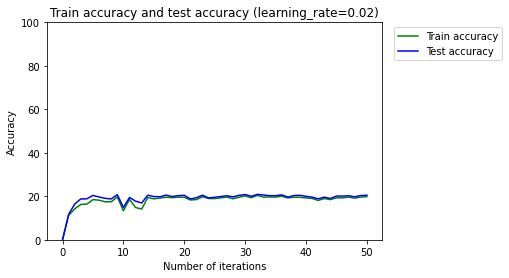

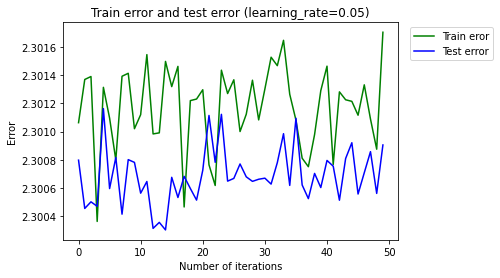

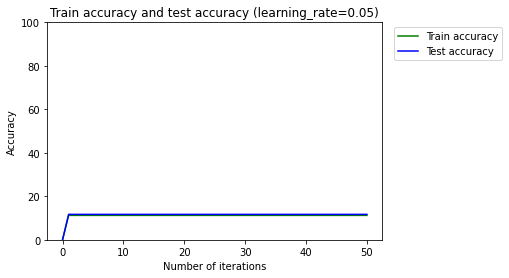

In [38]:
# hyperparameters to be tuned
learning_rates = [0.001, 0.01, 0.02, 0.05]

for i, learning_rate in enumerate(learning_rates):
    plot_loss_acc(filename=i+8, title=f"learning_rate={learning_rates[i]}") 

### width of the hidden layer

- change the width of the hidden layer, keeping the activation function that performs best. 

- results: n_hidden_1=256 has highest test accuracy of 96.3% occurred after epoch 47.

    32: The best validation accuracy of 94.450 occurred after epoch 49.
    
    64: The best validation accuracy of 95.300 occurred after epoch 38.
    
    128: The best validation accuracy of 95.700 occurred after epoch 37.
    
    256: The best validation accuracy of 96.300 occurred after epoch 47.

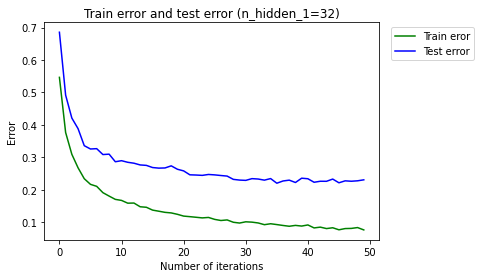

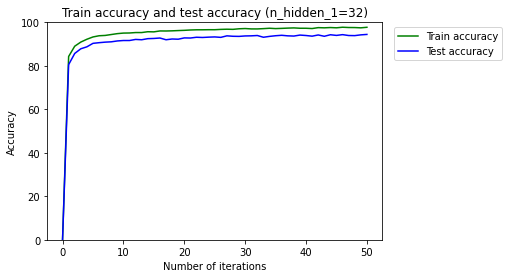

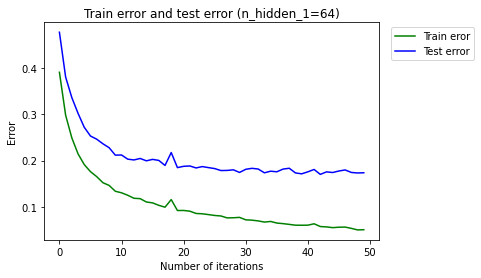

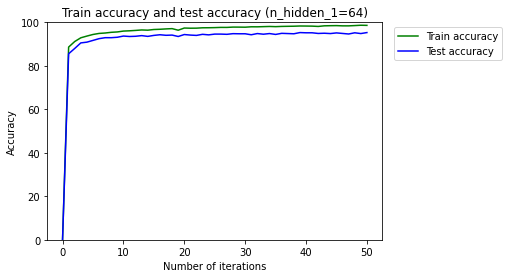

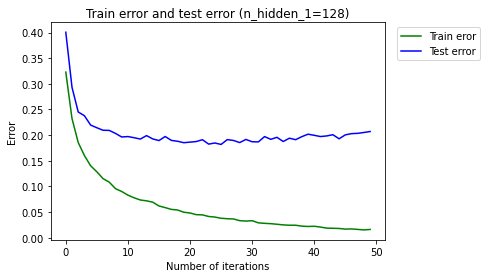

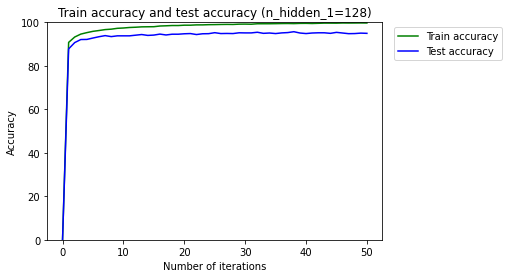

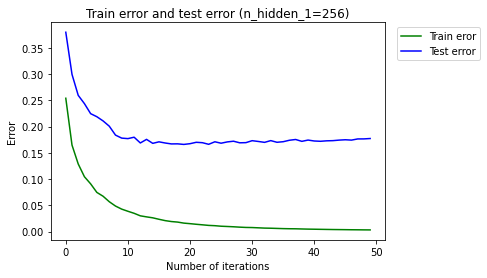

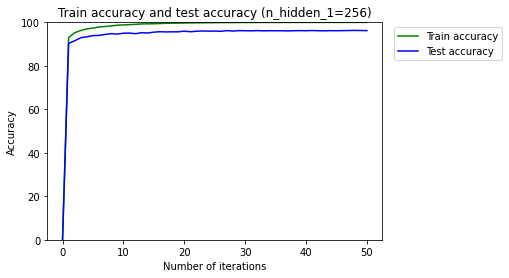

In [42]:
# hyperparameters to be tuned
n_hidden_1s = [32, 64, 128, 256]
for i, n_hidden_1 in enumerate(n_hidden_1s):
    plot_loss_acc(filename=i+12, title=f"n_hidden_1={n_hidden_1s[i]}") 


### activation

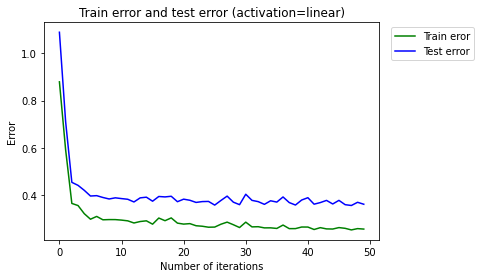

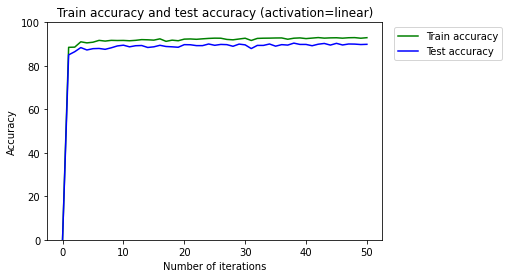

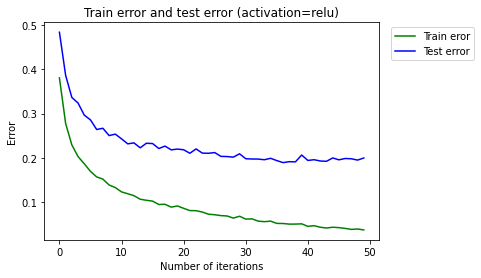

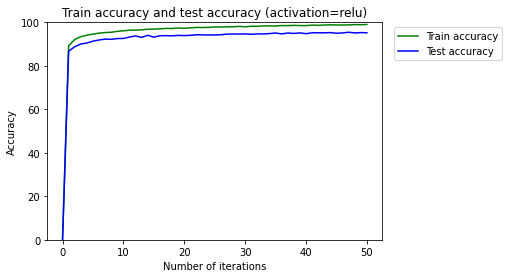

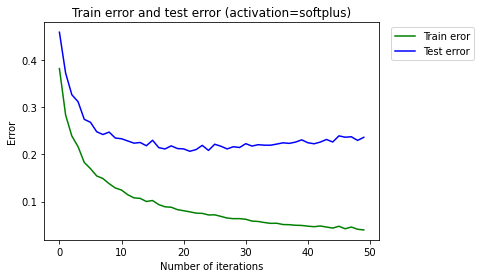

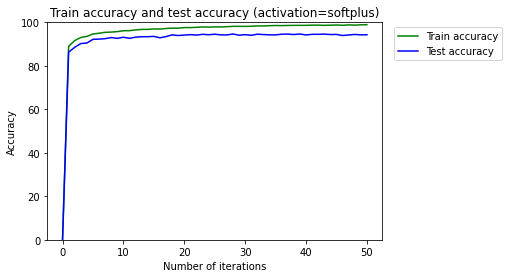

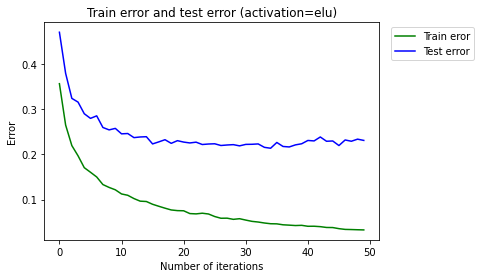

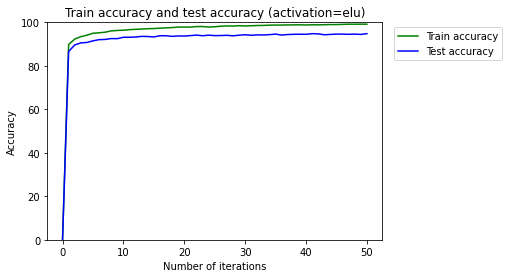

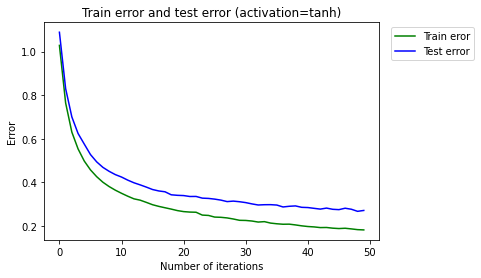

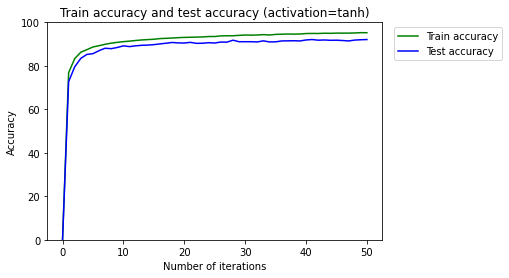

In [24]:
# hyperparameters to be tuned
activations = ['linear', 'relu', 'softplus', 'elu', 'tanh']

for i, activation in enumerate(activations):
    plot_loss_acc(filename=i+1, title=f"activation={activations[i]}") 


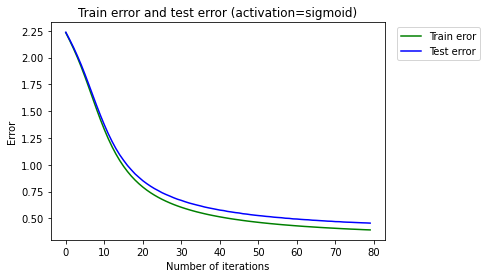

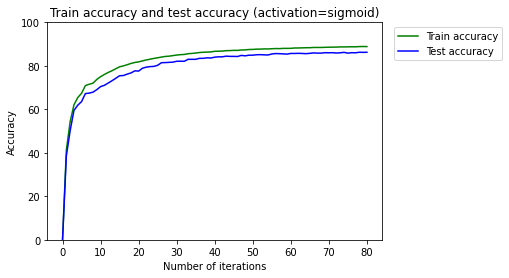

In [30]:
plot_loss_acc(filename=6, title=f"activation={activation}") 


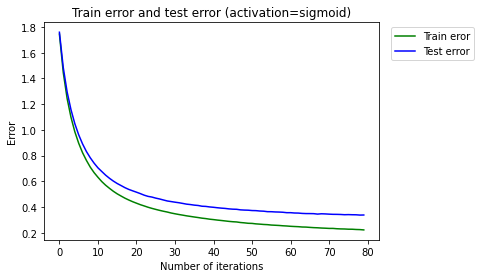

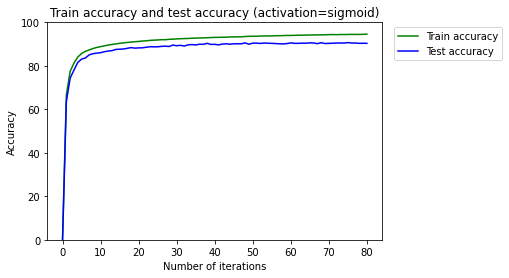

In [33]:
plot_loss_acc(filename=i, title=f"activation={activation}") 
 

### optimizer

Experiment with the optimizer of your network.

Using Adam optimizer doesn’t converge while using SGD optimizer converge well with fine-tuned hyperparameters.


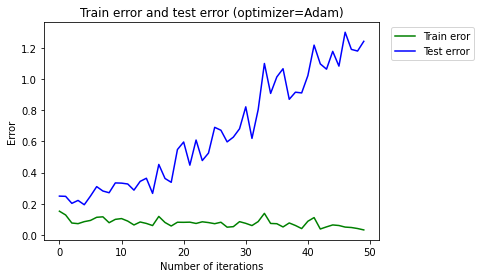

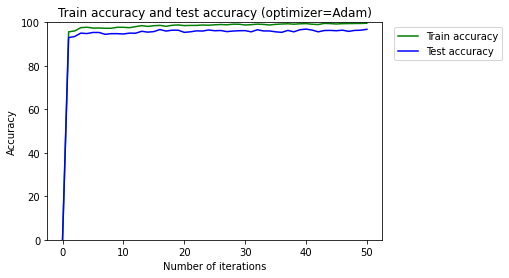

In [120]:
plot_loss_acc(filename=i, 
              title=f"optimizer=Adam")

### depth of NN : number of layers

- Lastly, try adding additional layers to your network. 

    How do 3, 4, and 5 layer networks perform?

    Is there a point where accuracy stops increasing?


- results: 3 layer network performs best

    after 3 layers, accuracy stops increasing when increasing number of layers

    2: highest test accuracy of 96.3% occurred after epoch 47.

    3: The best validation accuracy of 96.600 occurred after epoch 40

    4: The best validation accuracy of 96.450 occurred after epoch 48. 

    5: The best validation accuracy of 96.450 occurred after epoch 38. 
    

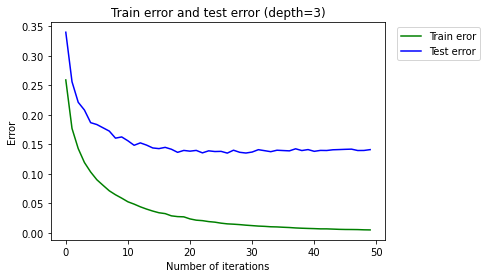

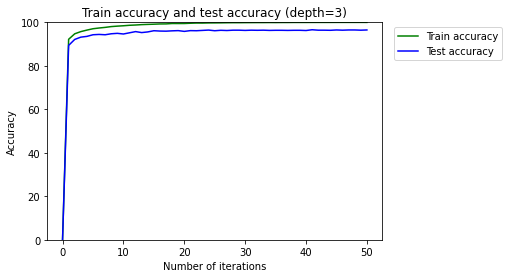

In [46]:
plot_loss_acc(filename=i, 
              title=f"depth=3")

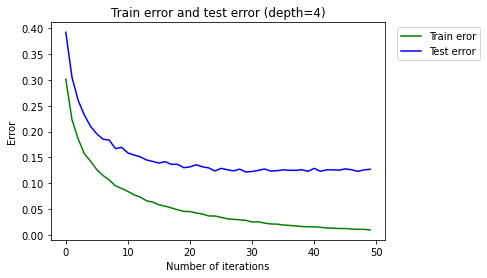

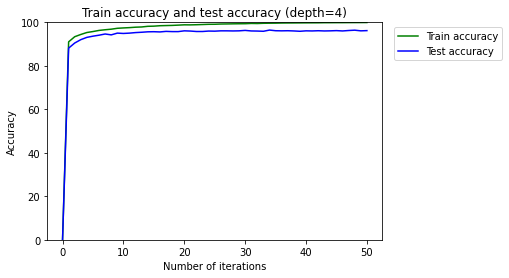

In [53]:
plot_loss_acc(filename=i, 
              title=f"depth=4")

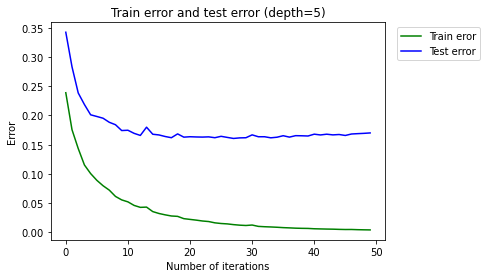

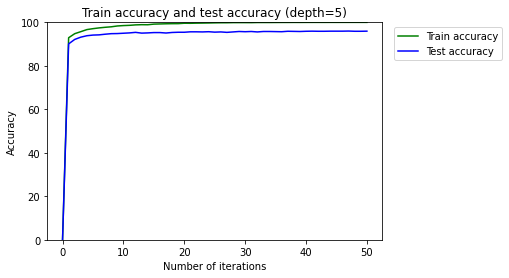

In [50]:
plot_loss_acc(filename=i, 
              title=f"depth=5")

2.	Create a plot of the training and test error vs the number of iterations. 

    How many iterations are sufficient to reach good performance?

50 epochs

## confusion matrix

3.	Print a confusion matrix showing which digits were misclassified, and what they were misclassified as. 

    What numbers are frequently confused with one another by your model? 
    
    You may use sklearn's confusion matrix function to generate the matrix.

Text(0.5, 1.1, 'Confusion matrix')

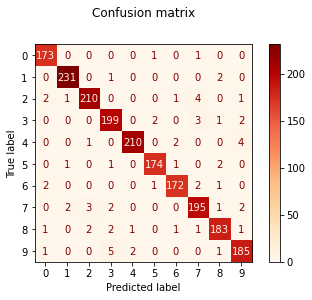

In [114]:
model = Fully_Connected_Neural_Net(num_input, num_classes,
                                   activation=activation,
                                   n_hidden_1=n_hidden_1,
                                   n_hidden_2=n_hidden_2)
filename = "./results/checkpoint16.pt"
model.load_state_dict(torch.load(filename))
test_preds = model(test_data).detach().argmax(dim=-1)

cm = confusion_matrix(test_labels, test_preds)

display_labels = unique_labels(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=display_labels)
disp.plot(
        cmap="OrRd", #"viridis"
        ax=None,
        xticks_rotation='horizontal',
        values_format=None,
        colorbar=True,
    )
plt.title("Confusion matrix",y=1.1)

- answer: 

    number 2 is frequently misclassified as number 7 (4/219)
    
    number 4 is frequently misclassified as number 9 (4/217)
    
    number 9 is frequently misclassified as number 3 (5/294)